# `pyrealsense` jupyter example

In [1]:
import pyrealsense as pyrs
from pyrealsense.constants import rs_option

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import NoNorm
%matplotlib inline

import cv2
import time

In [2]:
# Enumerate all available devices:
with pyrs.Service() as serv:
    for dev in serv.get_devices():
        print(dev)

{'id': 0, 'name': 'Intel RealSense R200', 'serial': '2411007334', 'firmware': '1.0.72.06', 'is_streaming': 0}


## Accessing Color Streams

In [3]:
# Define simple function that uses `matplotlib` to visualize a given frame and its channels separately:
def show_rgb_frame(frame, labels='RGB'):
    plt.figure(figsize=(16, 3))
    plt.subplot(1, 4, 1)
    plt.imshow(frame, aspect='auto', norm=NoNorm())
    plt.title(labels)
    plt.xticks([])
    plt.yticks([])

    for chn in range(3):
        plt.subplot(1, 4, chn+2)
        plt.imshow(frame[:, :, chn], aspect='auto', norm=NoNorm())
        plt.title(labels[chn])
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    
def show_yuv_frame(frame):
    plt.figure(figsize=(16, 3))
    plt.subplot(1, 4, 1)
    # Use opencv to convert YUYV buffer to  RGB
    conv = cv2.cvtColor(frame, cv2.COLOR_YUV2RGB_YUYV)
    plt.imshow(conv, aspect='auto', norm=NoNorm())
    plt.title('YUV')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(1, 4, 2)
    plt.imshow(frame[:, :, 0], aspect='auto', norm=NoNorm())
    plt.title('Y')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(1, 4, 3)
    plt.imshow(frame[::2, ::2, 1], aspect='auto', norm=NoNorm())
    plt.title('U')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(1, 4, 4)
    plt.imshow(frame[1::2, 1::2, 1], aspect='auto', norm=NoNorm())
    plt.title('V')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

In [4]:
def plot_color_frame(color_format='rgb', n_frames=1, wait=1.):
    # Initialize service
    with pyrs.Service() as serv:
        # Initiliaze color stream with given color format
        color_stream = pyrs.stream.ColorStream(color_format=color_format)
        
        # Initialize device
        with serv.Device(streams=(color_stream,)) as dev:
            
            # Wait for the device to initialize. Can be skipped but
            # the first few frames will not contain correct colors
            time.sleep(wait)
            dev.wait_for_frames()
            
            # Plot `n_frames` frames
            for _ in range(n_frames):
                
                frame = dev.color  # Access image buffer
                
                # Plot frame depending on format
                if color_format != 'yuv':
                    show_rgb_frame(frame, labels=color_format.upper())
                else:
                    show_yuv_frame(frame)
                    
                dev.wait_for_frames()  # Wait for the next frame

/home/joaopedro/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/joaopedro/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


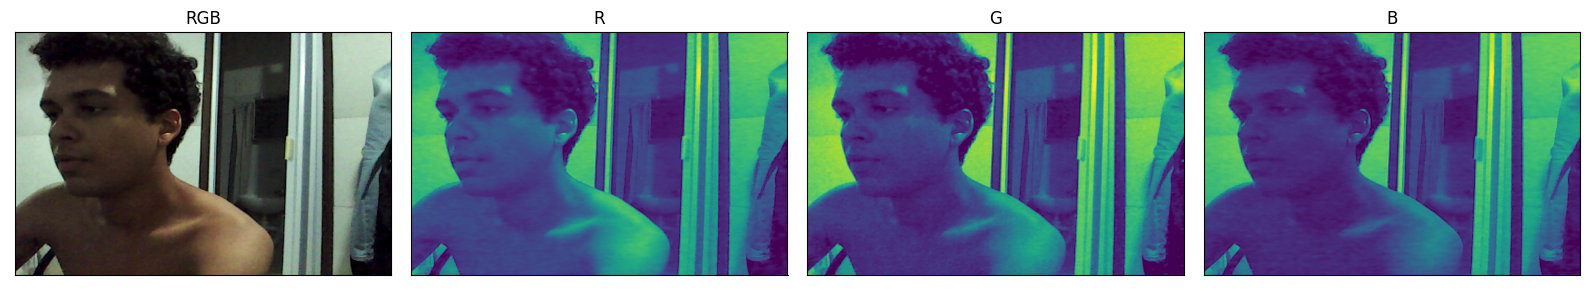

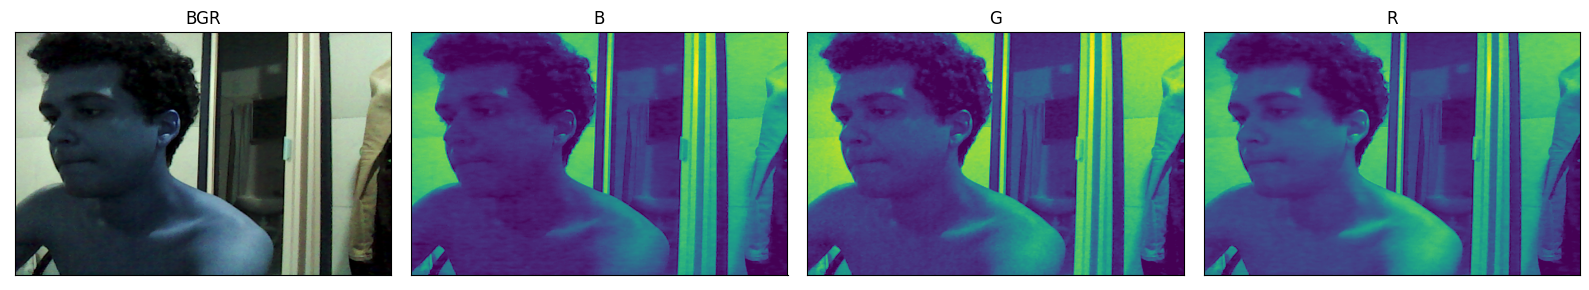

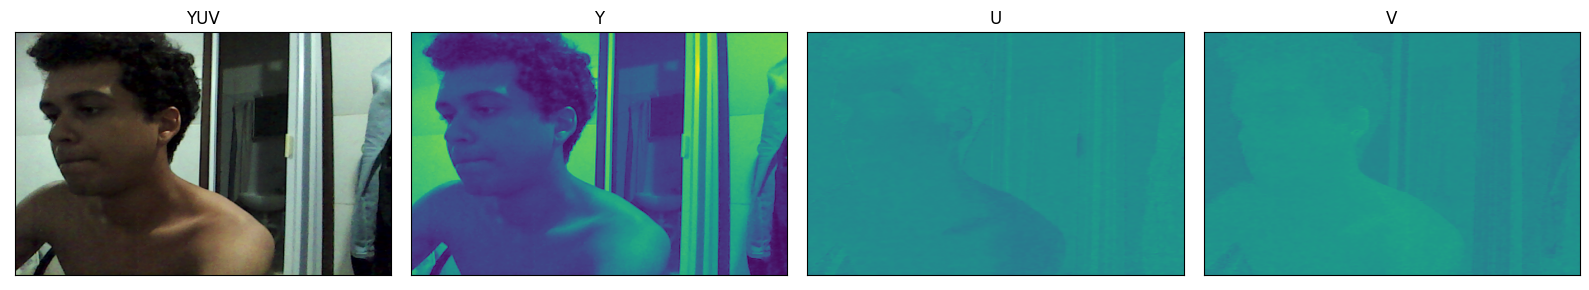

In [5]:
for fmt in ('rgb', 'bgr', 'yuv'):
    # Call plot function for each format once
    plot_color_frame(fmt)

## Accessing Depth Streams

In [6]:
def convert_z16_to_rgb(frame):
    '''Python implementation of librealsense make_depth_histogram()
    
    See source code:
    https://github.com/IntelRealSense/librealsense/blob/master/examples/example.hpp#L10-L33
    '''
    
    # calculate depth histogram
    hist, edges = np.histogram(frame, bins=0x10000)
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 2, 1)
    plt.scatter(edges[:-1], hist, s=1)
    plt.title('Depth histogram')
    
    # calculate cumulative depth histogram
    hist = np.cumsum(hist)
    hist -= hist[0]
    plt.subplot(1, 2, 2)
    plt.scatter(edges[:-1], hist, s=1)
    plt.title('Cumulative depth histogram')
    plt.tight_layout()
    rgb_frame = np.zeros(frame.shape[:2] + (3,), dtype=np.uint8)
    
    zeros = frame==0
    non_zeros = frame!=0
    
    f = hist[frame[non_zeros]] * 255 / hist[0xFFFF]
    rgb_frame[non_zeros, 0] = f
    rgb_frame[non_zeros, 1] = 0
    rgb_frame[non_zeros, 2] = 255 - f
    rgb_frame[zeros, 0] = 0
    rgb_frame[zeros, 1] = 5
    rgb_frame[zeros, 2] = 20
    return rgb_frame

def plot_depth_frame(n_frames=1, wait=1.):
    # Initialize service
    with pyrs.Service() as serv:
        depth_stream = pyrs.stream.DepthStream()
        # Initialize device
        with serv.Device(streams=(depth_stream,)) as dev:
            
            try:  # set custom gain/exposure values to obtain good depth image
                custom_options = [(rs_option.RS_OPTION_R200_LR_EXPOSURE, 30.0),
                                  (rs_option.RS_OPTION_R200_LR_GAIN, 100.0)]
                dev.set_device_options(*zip(*custom_options))
            except pyrs.RealsenseError:
                pass  # options are not available on all devices
            
            # Wait for device to initialize
            time.sleep(wait)
            dev.wait_for_frames()
            
            # Get n frames
            for _ in range(n_frames):
                frame = dev.depth  # Access image buffer
                frame = convert_z16_to_rgb(frame)  # convert to RGB
                plt.figure(figsize=(16, 12))
                plt.imshow(frame, aspect='auto', norm=NoNorm())
                plt.xticks([])
                plt.yticks([])


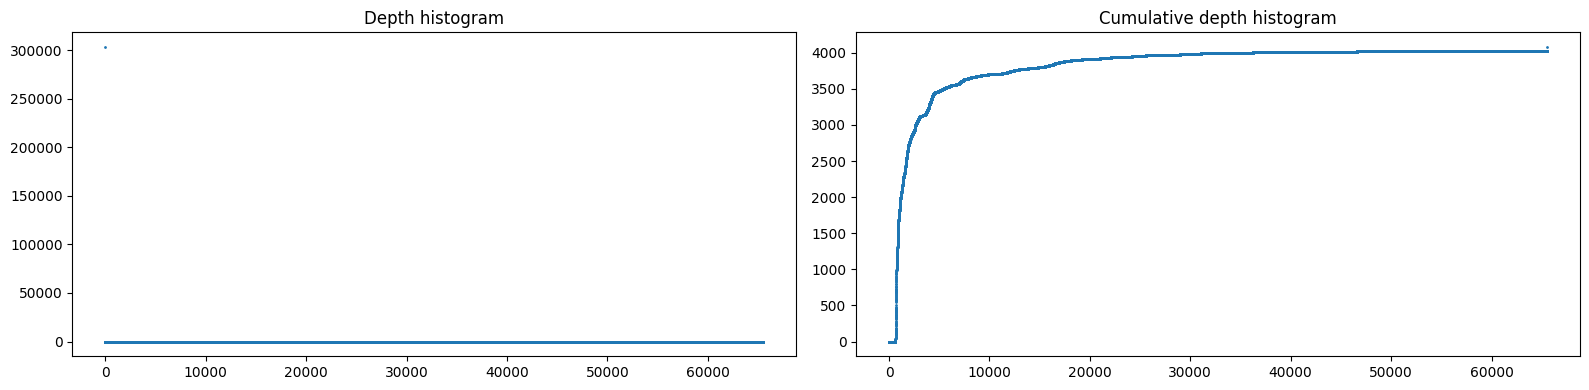

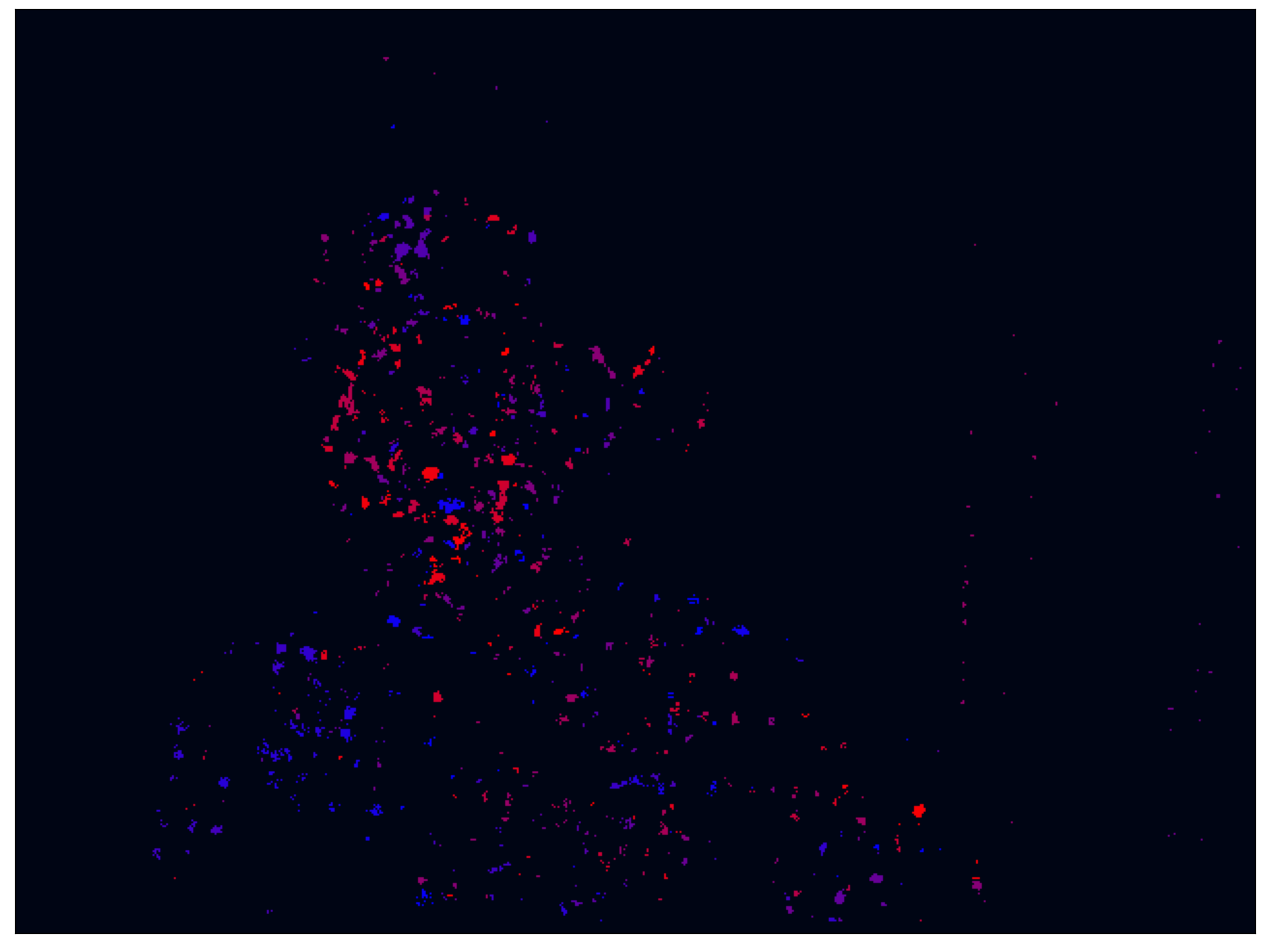

In [7]:
plot_depth_frame(1)